In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2

from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive 
from google.colab.patches import cv2_imshow	


In [3]:
################# Parameters #####################

path = "/content/drive/My Drive/Colab Notebooks/Proyecto Final/ASL Training/myData"  # folder with all the class folders
labelFile = '/content/drive/My Drive/Colab Notebooks/Proyecto Final/ASL Training/labels.csv'  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 10  #cantidad de iteraciones
imageDimesions = (200, 200, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

drive.mount('/content/drive')
###################################################

Mounted at /content/drive


In [4]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 5
Importing Classes.....
0 1 2 3 4  


In [4]:
############################### Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

print("Split Data")

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

Split Data


In [5]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[
    0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0] == y_validation.shape[
    0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:] == (imageDimesions)), " The dimesions of the Training images are wrong "
assert (X_validation.shape[1:] == (imageDimesions)), " The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:] == (imageDimesions)), " The dimesionas of the Test images are wrong"


Data Shapes
Train(9585, 200, 200, 3) (9585,)
Validation(2397, 200, 200, 3) (2397,)
Test(2996, 200, 200, 3) (2996,)


data shape  (5, 2) <class 'pandas.core.frame.DataFrame'>


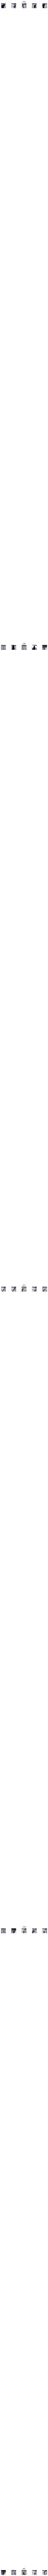

In [6]:
############################### READ CSV FILE
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))



[1907, 1956, 1895, 1934, 1893]


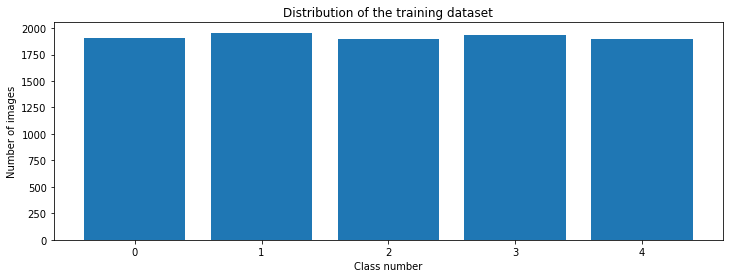

In [7]:
############################### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [9]:
############################### PREPROCESSING THE IMAGES

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img


X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
#cv2.imshow("GrayScale Images", X_train[random.randint(0, len(X_train) - 1)])  # TO CHECK IF THE TRAINING IS DONE PROPERLY
cv2_imshow("GrayScale Images",X_train[random.randint(0, len(X_train) - 1)])

error: ignored

In [10]:
############################### ADD A DEPTH OF 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

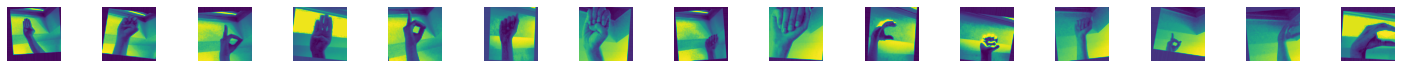

In [11]:
############################### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,
                       batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [7]:
############################### CONVOLUTION NEURAL NETWORK MODEL
print(" ***********************************CONVOLUTION NEURAL NETWORK MODEL*************************************")
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0], imageDimesions[1], 1),
                      activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(adam_v2.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

############################### TRAIN
print(" *********************************** TRAIN *************************************")
model = myModel()
print(model.summary())
history = model.fit(dataGen.flow(X_train,
                                 y_train,
                                 batch_size=batch_size_val),
                    steps_per_epoch=len(X_train)//batch_size_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    shuffle=1)

 ***********************************CONVOLUTION NEURAL NETWORK MODEL*************************************
 *********************************** TRAIN *************************************


NameError: ignored

 *********************************** TRAIN *************************************


NameError: ignored

Mounted at /content/drive
Total Classes Detected: 5
Importing Classes.....
0 1 2 3 4  
Split Data
Data Shapes
Train(9585, 200, 200, 3) (9585,)
Validation(2397, 200, 200, 3) (2397,)
Test(2996, 200, 200, 3) (2996,)
data shape  (5, 2) <class 'pandas.core.frame.DataFrame'>
[1916, 1946, 1904, 1889, 1930]


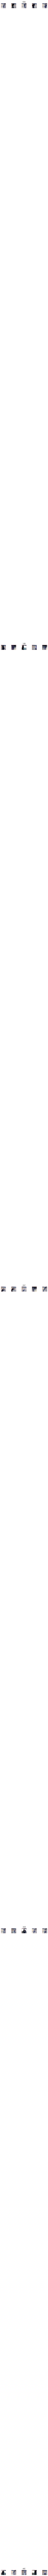

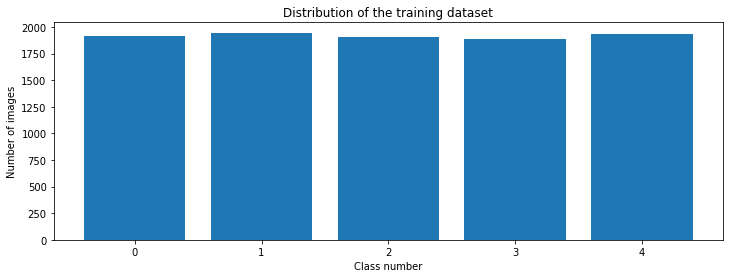

DisabledFunctionError: ignored

In [ ]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# STORE THE MODEL AS A PICKLE OBJECT
model.save('model_train.h5')

pickle_out = open("model.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model, pickle_out)
pickle_out.close()
print("STORE THE MODEL AS A PICKLE OBJECT")
cv2.waitKey(0)